In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
# specify directories
my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
my_corr_path = '/glade/u/home/zcleveland/scratch/ERA5/correlations/'  # path to my correlation datasets
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/correlations/'  # path to generated figures

In [3]:
# define list of variables

# surface instantaneous variables
sfc_instan_list = [
    'sd',  # snow depth  (m of water equivalent)
    'msl',  # mean sea level pressure (Pa)
    'tcc',  # total cloud cover (0-1)
    'stl1',  # soil temp layer 1 (K)
    'stl2',  # soil temp layer 2 (K)
    'stl3',  # soil temp layer 3 (K)
    'stl4',  # soil temp layer 4 (K)
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3)
    'swvl2',  # soil volume water content layer 2 (m^3 m^-3)
    'swvl3',  # soil volume water content layer 3 (m^3 m^-3)
    'swvl4',  # soil volume water content layer 4 (m^3 m^-3)
    '2t',  # 2 meter temp (K)
    '2d',  # 2 meter dew point (K)
    'ishf',  # instant surface heat flux (W m^-2)
    'ie',  # instant moisture flux (kg m^-2 s^-1)
    'cape',  # convective available potential energy (J kg^-1)
    'tcw',  # total column water (kg m^-2) -- sum total of solid, liquid, and vapor in a column
    'sstk',  # sea surface temperature (K)
]

# surface accumulation variables
sfc_accumu_list = [
    'lsp',  # large scale precipitation (m of water)
    'cp',  # convective precipitation (m of water)
    'tp',  # total precipitation (m of water) -- DERIVED
    'sshf',  # surface sensible heat flux (J m^-2)
    'slhf',  # surface latent heat flux (J m^-2)
    'ssr',  # surface net solar radiation (J m^-2)
    'str',  # surface net thermal radiation (J m^-2)
    'sro',  # surface runoff (m)
    'sf',  # total snowfall (m of water equivalent)
    'ssrd',  # surface solar radiation downwards (J m^-2)
    'strd',  # surface thermal radiation downwards (J m^-2)
    'ttr',  # top net thermal radiation (OLR, J m^-2) -- divide by time (s) for W m^-2
]

# pressure level variables
pl_var_list = [
    # 'pv',  # potential vorticity (K m^2 kg^-1 s^-1)
    # 'crwc',  # specific rain water content (kg kg^-1)
    # 'cswc',  # specific snow water content (kg kg^-1)
    'z',  # geopotential (m^2 s^2)
    't',  # temperature (K)
    'u',  # u component of wind(m s^-1)
    'v',  # v component of wind (m s^-1)
    'q',  # specific humidity (kg kg^-1)
    'w',  # vertical velo|city (Pa s^-1)
    # 'vo',  # vorticity - relative (s^-1)
    # 'd',  # divergence (s^-1)
    'r',  # relative humidity (%)
    # 'clwc',  # specific cloud liquid water content
    # 'ciwc',  # specific cloud ice water content
    # 'cc',  # fraction of cloud cover (0-1)
]

# NAM variables
NAM_var_list = [
    'onset',
    'retreat',
    'length'
]

In [4]:
var_dict = {
    'sd': 'Snow Depth',
    'msl': 'Mean Sea Level Pressure',
    'tcc': 'Total Cloud Cover',
    'stl1': 'Soil Temp Layer 1',
    'stl2': 'Soil Temp Layer 2',
    'stl3': 'Soil Temp Layer 3',
    'stl4': 'Soil Temp Layer 4',
    'swvl1': 'Soil Volume Water Content Layer 1',
    'swvl2': 'Soil Volume Water Content Layer 2',
    'swvl3': 'Soil Volume Water Content Layer 3',
    'swvl4': 'Soil Volume Water Content Layer 4',
    '2t': '2 Meter Temp',
    '2d': '2 Meter Dew Point',
    'ishf': 'Instant Surface Heat Flux',
    'ie': 'Instant Moisture Flux',
    'cape': 'Convective Available Potential Energy',
    'tcw': 'Total Column Water',
    'sstk': 'Sea Surface Temperature',
    'lsp': 'Large Scale Precipitation',
    'cp': 'Convective Precipitation',
    'tp': 'Total Precipitation',
    'sshf': 'Surface Sensible Heat Flux',
    'slhf': 'Surface Latent Heat Flux',
    'ssr': 'Surface Net Solar Radiation',
    'str': 'Surface Net Thermal Radiation',
    'sro': 'Surface Runoff',
    'sf': 'Total Snowfall',
    'ssrd': 'Surface Solar Radiation Downwards',
    'strd': 'Surface Thermal Radiation Downwards',
    'ttr': 'Top Net Thermal Radiation (OLR)',
    'z': 'Geopotential',
    't': 'Temperature',
    'u': 'U Component of Wind',
    'v': 'V Component of Wind',
    'q': 'Specific Humidity',
    'w': 'Vertical Velocity',
    'r': 'Relative Humidity',
    'onset': 'Onset',
    'retreat': 'Retreat',
    'length': 'Length'
}

In [5]:
var_units = {
    'sd': '$(m)$',
    'msl': '$(Pa)$',
    'tcc': '$(0-1)$',
    'stl1': '$(K)$',
    'stl2': '$(K)$',
    'stl3': '$(K)$',
    'stl4': '$(K)$',
    'swvl1': '$(m^3 m^{-3})$',
    'swvl2': '$(m^3 m^{-3})$',
    'swvl3': '$(m^3 m^{-3})$',
    'swvl4': '$(m^3 m^{-3})$',
    '2t': '$(K)$',
    '2d': '$(K)$',
    'ishf': '$(W m^{-2})$',
    'ie': '$(kg m^{-2} s^{-1})$',
    'cape': '$(J kg^{-1})$',
    'tcw': '$(kg m^{-2})$',
    'sstk': '$(K)$',
    'lsp': '$(m)$',
    'cp': '$(m)$',
    'tp': '$(m)$',
    'sshf': '$(J m^{-2})$',
    'slhf': '$(J m^{-2})$',
    'ssr': '$(J m^{-2})$',
    'str': '$(J m^{-2})$',
    'sro': '$(m)$',
    'sf': '$(m)$',
    'ssrd': '$(J m^{-2})$',
    'strd': '$(J m^{-2})$',
    'ttr': '$(J m^{-2})$',
    'z': '$(m^2 s^{-2})$',
    't': '$(K)$',
    'u': '$(m s^{-1})$',
    'v': '$(m s^{-1})$',
    'q': '$(kg kg^{-1})$',
    'w': '$(Pa s^{-1})$',
    'r': '$(\%)$',
    'onset': '',
    'retreat': '',
    'length': ''
}

In [7]:
# REWORK
# define a function to calculate the correlation between
# any two variables in certain months
def calc_correlation(var1='swvl1', var1_level=700, var1_month_list=[3, 4, 5], var1_region='cp',
                     var2='tp', var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw'):

    # months list
    var1_months = month_num_to_name(var=var1, months=var1_month_list)
    var2_months = month_num_to_name(var=var2, months=var2_month_list)

    fn_list = [str(var1), str(var1_months), str(var1_region), str(var2), str(var2_months), str(var2_region)]
    fn_core = '_'.join([i for i in fn_list if i != ''])

    # filename and path
    out_fn = f'corr_{fn_core}.nc'
    # out_fp = os.path.join(my_corr_path, 'domain', out_fn)

    # # check existence of file already
    # if os.path.exists(out_fp):
    #     print(f'File already exists for: {out_fn}')
    #     print('\nSkipping . . .')
        # return

    # open datasets

    # var 1
    if ((var1 in sfc_instan_list) or (var1 in sfc_accumu_list)):
        var1_data = open_sfc_data(var=var1, region=var1_region, months=var1_month_list)
    elif var1 in pl_var_list:
        var1_data = open_pl_data(var=var1, p_level=var1_level, months=var1_month_list)
    elif var1 in NAM_var_list:
        var1_data = open_NAM_data(var=var1)
    else:
        print('Something went wront . . .')
        return

    # var 2
    if ((var2 in sfc_instan_list) or (var2 in sfc_accumu_list)):
        var2_data = open_sfc_data(var=var2, region=var2_region, months=var2_month_list)
    elif var2 in pl_var_list:
        var2_data = open_pl_data(var=var2, p_level=var2_level, months=var2_month_list)
    elif var2 in NAM_var_list:
        var2_data = open_NAM_data(var=var2)
    else:
        print('Something went wront . . .')
        return

    if ((var1_data is None) or (var2_data is None)):
        print(f'No files were found a var: \n{var1_data}\n{var2_data}')
        return

    # calculate correlation
    var_corr = xr.corr(var1_data, var2_data, dim='year')
    return var_corr, out_fn

    # save to netCDF file
    # var_corr.to_netcdf(out_fp)


# define a function to turn a list of integers into months
def month_num_to_name(var, months):

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    if var in NAM_var_list:
        var_months = ''
    elif len(months) == 1:
        var_months = calendar.month_name[months[0]]  # use full month name if only 1 month
    elif ((len(months) > 1) & (len(months) <= 12)):
        var_months = ''.join([calendar.month_name[m][0] for m in months])
    return var_months


# define function to open pressure level datasets
def open_pl_data(var='z', p_level=700, months=None):

    # grab files for pl var
    files = glob.glob(f'{my_era5_path}dsw/*/pl/{var.lower()}_*_dsw.nc')
    files.sort()

    if not files:
        return None

    # open dataset
    ds = xr.open_mfdataset(files, data_vars='minimal', coords='minimal', parallel=True, chunks={'level': 1})

    # subset the data bas
    da = ds[var.upper()].sel(level=p_level, drop=True)
    var_data = da.sel(time=da['time.month'].isin(months)).groupby('time.year').mean(dim='time')
    return var_data


# define a function to open surface data
def open_sfc_data(var='swvl1', region='dsw', months=None):

    # grab files for sfc var
    if region.lower() == 'dsw':
        files = glob.glob(f'{my_era5_path}dsw/*/{var.lower()}_*_dsw.nc')
    elif region.lower() == 'cp':
        files = glob.glob(f'{my_era5_path}cp/{var.lower()}_198001_201912_cp.nc')
    files.sort()

    if not files:
        return None

    # open dataset
    ds = xr.open_mfdataset(files)

    # pull out actual variable name in the dataset since they can be different names/capitalized
    var_name = [v for v in ds.data_vars.keys() if f'{var.upper()}' in v][0]
    da = ds[var_name]
    # get data from var
    if var.lower() in sfc_instan_list:
        var_data = da.sel(time=da['time.month'].isin(months)).groupby('time.year').mean(dim='time')
    elif var.lower() in sfc_accumu_list:
        var_data = da.sel(time=da['time.month'].isin(months)).groupby('time.year').sum(dim='time')
    return var_data


# define a function to open onset, retreat, and length of NAM data
def open_NAM_data(var='onset'):

    # grab files for NAM data
    files = glob.glob(f'{my_era5_path}dsw/NAM_{var.lower()}.nc')
    files.sort()

    if not files:
        return None

    # open dataset
    ds = xr.open_mfdataset(files)
    ds['year'] = ds['year'].dt.year  # convert to only year.  e.g. 2012-01-01 -> 2012

    # pull out actual variable name in the dataset since they can be different
    if ((var.lower() == 'onset') or (var.lower() == 'retreat')):
        da = ds['date'].dt.dayofyear
    elif var.lower() == 'length':
        da = ds['dayofyear']
    return da

In [8]:
# OLD
# define a function to calculate the correlation between
# any given parameter and the NAM onset date
def calc_old_correlation(NAM_var='onset', var='swvl1', months=[3, 4, 5], cp_flag=True):

    # create string to make directory path for figure save
    if cp_flag:
        var_region = 'cp'
    else:
        var_region = 'dsw'

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    var_months = ''.join([calendar.month_name[m][0] for m in months])

    # path to save figures
    out_fn = f'corr_{var}_{NAM_var}_{var_months}_{var_region}.nc'
    # out_fp = os.path.join(my_corr_path, var_region, out_fn)

    # # check existence of file already
    # if os.path.exists(out_fp):
    #     print(f'File already exists for: {out_fn}')
    #     print('\nSkipping . . .')
    #     return

    # open onset dataset
    NAM_ds = xr.open_dataset(os.path.join(my_era5_path, f'dsw/NAM_{NAM_var}.nc'))
    NAM_ds['year'] = NAM_ds['year'].dt.year  # convert to only year.  e.g. 2012-01-01 -> 2012

    # extract data array of the NAM variable
    if NAM_var == 'length':
        NAM_da = NAM_ds['dayofyear']
        NAM_data = NAM_da.astype('float32')
    else:
        NAM_da = NAM_ds['date']
        NAM_data = NAM_da.dt.dayofyear.astype('float32')

    # open var dataset
    if cp_flag:
        var_files = glob.glob(f'{my_era5_path}{var_region}/*{var}_198001_201912_cp.nc')
        if len(var_files) != 1:
            print(f'Too many files for var_region: cp -- {len(var_files)}\n')
            print('Skipping . . .')
            return
    else:
        var_files = glob.glob(f'{my_era5_path}{var_region}/*/*{var}_*_{var_region}.nc')
        if len(var_files) != 40:
            print(f'Too many files for var_region: cp -- {len(var_files)}\n')
            print('Skipping . . .')
            return

    var_ds = xr.open_mfdataset(var_files)

    # pull out actual variable name in the dataset since they can be different names/capitalized
    var_name = [v for v in var_ds.data_vars.keys() if f'{var.upper()}' in v][0]
    var_da = var_ds[var_name]

    # get data from var
    if 'AVG' in var_name:
        mon_mean = var_da.resample(time='1M').mean()
        var_mon_mean = mon_mean.sel(time=mon_mean['time.month'].isin(months))
        var_data = var_mon_mean.groupby('time.year').mean(dim='time')
    else:
        mon_sum = var_da.resample(time='1M').sum()
        var_mon_sum = mon_sum.sel(time=mon_sum['time.month'].isin(months))
        var_data = var_mon_sum.groupby('time.year').sum(dim='time')

    # calculate correlation
    var_corr = xr.corr(NAM_data, var_data, dim='year')
    return var_corr, out_fn

    # save correlation as netcdf file
    # var_corr.to_netcdf(out_fp)

In [9]:
newcorr, newfn = calc_correlation(var1='swvl1', var1_level=700, var1_month_list=[3, 4, 5], var1_region='cp',
                                  var2='onset', var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw')
oldcorr, oldfn = calc_old_correlation(NAM_var='onset', var='swvl1', months=[3, 4, 5], cp_flag=True)

In [ ]:
newcorr

In [11]:
oldcorr

<xarray.DataArray (latitude: 81, longitude: 81)>
dask.array<truediv, shape=(81, 81), dtype=float64, chunksize=(81, 81), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 40.0 39.75 39.5 39.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 240.0 240.2 240.5 240.8 ... 259.5 259.8 260.0

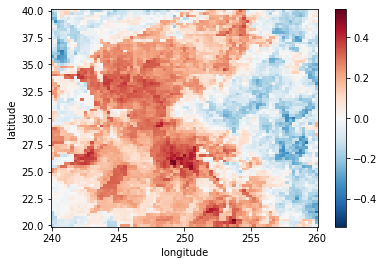

In [18]:
newcorr.plot()

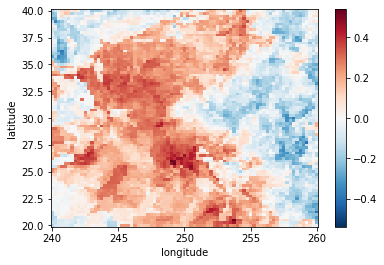

In [13]:
oldcorr.plot()

In [ ]:
var1_list = ['swvl1']
var2_list = ['onset', 'retreat', 'length', 'tp']
newcorr1 = []
newname1 = []
newcorr2 = []
newname2 = []
newcorr3 = []
newname3 = []
newcorr4 = []
newname4 = []
for var1 in var1_list:
    for var2 in var2_list:
        corr1, name1 = calc_correlation(var1=var1, var1_level=700, var1_month_list=[3, 4, 5], var1_region='cp',
                                         var2=var2, var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw')
        newcorr1.append(corr1)
        newname1.append(name1)
        corr2, name2 = calc_correlation(var1=var2, var1_level=700, var1_month_list=[3, 4, 5], var1_region='dsw',
                                         var2=var1, var2_level=700, var2_month_list=[6, 7, 8], var2_region='cp')
        newcorr2.append(corr2)
        newname2.append(name2)
        corr3, name3 = calc_correlation(var1=var1, var1_level=700, var1_month_list=[6, 7, 8], var1_region='cp',
                                         var2=var2, var2_level=700, var2_month_list=[3, 4, 5], var2_region='dsw')
        newcorr3.append(corr3)
        newname3.append(name3)
        corr4, name4 = calc_correlation(var1=var2, var1_level=700, var1_month_list=[6, 7, 8], var1_region='dsw',
                                         var2=var1, var2_level=700, var2_month_list=[3, 4, 5], var2_region='cp')
        newcorr4.append(corr4)
        newname4.append(name4)

In [ ]:
def temp_plot(da, name):
    # plot the results
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    levels = np.arange(-1, 1.05, 0.05)
    # plot the data using contourf
    cf = plt.contourf(da.longitude, da.latitude,
                      da, levels=levels,
                      cmap='RdBu_r', vmin=-1, vmax=1, extend='both')

    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # plot features
    plt.title(name)
    plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient', pad=0.02)
    plt.tight_layout()
    # plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()